In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
total_ret_idx = pd.read_csv('/projects/Polygon/data/grf/totindex-em.csv', header=0, index_col=0, parse_dates=True)
total_ret = total_ret_idx.pct_change(1)
prc_idx = pd.read_csv('/projects/Polygon/data/grf/priceindex-em.csv', header=0, index_col=0, parse_dates=True)
prc_ret = prc_idx.pct_change(1)
fut_idx = pd.read_csv('/projects/Polygon/data/grf/fut1return-em.csv', header=0, index_col=0, parse_dates=True)
fut_idx.index = pd.to_datetime(fut_idx.index, unit = 'D', origin = '1899-12-30')
fut_ret = fut_idx.pct_change(1)

# add price return to any NA row of total return DataFrame
no_data_dates = total_ret[(total_ret.isnull().sum(axis=1) > 0).values].index
total_ret.loc[no_data_dates] = prc_ret.loc[no_data_dates]
# Make ERet by below rule
ERet = pd.concat([total_ret.loc[:'2007-12-31'], fut_ret.loc['2008-01-01':]], axis=0).iloc[1:]

ERet.fillna(0, inplace=True)
Eindex = (1. + ERet).cumprod()

In [3]:
RET = ERet  
RETfinal = RET
CSNUM = 0.35
for statrun in range(2):
    if statrun ==0:
        RET = ERet.iloc[:, :10]
    elif statrun==1:
        RET = ERet.iloc[:, 10:14]          
    index=Eindex.loc[:, RET.columns]

    Ret=RET
    fundwgt=1
    statwgt=1
    minobs=500
    Expanding=1
    short=0.2
    day1=24#rebalance
    day2=2
    nopos=0.4##middle section->neutral zone
    MA=[x /15 for x in [1,2,3,4,5]]

    CS=CSNUM # assets to long and short

    #Factor Portfolio construction
    Assetvol=0.02
    Strategyvol=0.02

    factorvol=0.02
    factorsd=260
    assetsd=260
    statsd=260
    ##volupdate trigger
    Volband=0.1

    ##carry score


#     cal <- create.calendar("Actual",weekdays=c("saturday", "sunday"))
#     TOM=as.data.frame(day(add.bizdays(rownames(Ret),1,cal)))
    TOM = Ret.index + pd.tseries.offsets.BDay(1)
#     print('TOM: ', TOM)
    TOM2 = pd.DataFrame([-short]*len(TOM), index = Ret.index)
#     print('TOM2: ', TOM2)
    TOM2[TOM.day >= day1] =1
    SIG=Ret*0+1
    SIG=pd.DataFrame(SIG.values* TOM2.values, index = TOM2.index, columns = Ret.columns)

    TSRV1=SIG*fundwgt#+SIG2

    # 1day forward signal of 0.2 since short =0.2

    short=0
    CSRV=index*0

    statday = (Ret.index+pd.tseries.offsets.DateOffset(months =1)).strftime('%Y-%m').unique()
    bible_idx = statday[36-short:len(statday)-short]
    bible_ls = []

    for i in range(len(bible_idx)):
        ave = np.mean(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month!= pd.to_datetime(bible_idx[i]).month)], axis=0)
        ave = ave.iloc[:len(index.columns)]
        bible_temp = np.mean(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month== pd.to_datetime(bible_idx[i]).month)], axis=0)/ \
                    np.std(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month== pd.to_datetime(bible_idx[i]).month)], axis=0) 
        bible_ls.append(bible_temp.iloc[:len(index.columns)])    
    
    bible = pd.DataFrame(bible_ls, index = bible_idx)

    # RV represents right value?? or rank value???
    RV1=bible.iloc[:,:len(index.columns)]
    print('RV1: ', RV1)
    
    truecount= np.round(1 - np.sum(np.isnan(RV1), axis =1)*CS)
#     print('true count1: ', truecount)
    truecount = np.tile(truecount, (len(RV1.columns), 1))
    print('true count2: ', truecount, truecount.shape)

    bibleRV = RV1.rank(axis=1, method = 'first').T
    bibleRV1 = (-RV1).rank(axis=1, method = 'first').T
    bibleRVpos=bibleRV*0
    bibleRVpos[bibleRV<=truecount]=-1
    bibleRVpos[bibleRV1<=truecount]=1
    print('biblervpos: ', bibleRVpos)
    
    for i in range(len(bible)):
        CSRV_ym = (pd.to_datetime(bible_idx[i])-pd.tseries.offsets.DateOffset(months =1)).strftime('%Y-%m')
        CSRV_range = CSRV[CSRV.index.strftime('%Y-%m') ==CSRV_ym]
        CSRV[CSRV.index.strftime('%Y-%m') ==CSRV_ym] = [bibleRVpos.iloc[:, i]*statwgt]*CSRV_range.shape[0]

    bibleTS1=bible
    bibleTS=bibleTS1*0
    bibleTS[bibleTS1<(-0.5)]=-1
    bibleTS[bibleTS1>(0.5)]=1
    TSRV=CSRV*0
    for i in range(len(bible)):
        TSRV_ym = (pd.to_datetime(bible_idx[i])).strftime('%Y-%m')
        TSRV_range = TSRV[TSRV.index.strftime('%Y-%m') ==TSRV_ym]
        TSRV[TSRV.index.strftime('%Y-%m') ==TSRV_ym] = [bibleTS.iloc[i, :]]*TSRV_range.shape[0]    
    
    AAA = [x for x in TSRV1 if x in TSRV]
    TSRV1 = TSRV1.loc[:, AAA]
    TSRV = TSRV.loc[:, AAA]
    
    TSRV=TSRV1*1+TSRV*0
    AAA = pd.Index(TSRV.index).intersection(CSRV.index)
    CSRV = CSRV.loc[AAA,:]
    TSRV = TSRV.loc[AAA,:]    
    
    if statrun==0:
      TSRVrun1=TSRV
      CSRVrun1=CSRV

    if statrun==1:
      TSRVrun2=TSRV
      CSRVrun2=CSRV
    
TSRV = pd.concat([TSRVrun1, TSRVrun2], axis=1)
CSRV = pd.concat([CSRVrun1, CSRVrun2], axis=1)





RV1:                 CN        KR        TW        IN        MY        ID        BR  \
2004-02 -0.146497  0.017509 -0.222287  0.058037 -0.183860  0.062635  0.022040   
2004-03 -0.112137 -0.025414  0.068947 -0.225590 -0.058754 -0.034173 -0.008363   
2004-04  0.115792  0.134563 -0.108484 -0.089906 -0.054442  0.181437  0.124415   
2004-05  0.159326  0.046133  0.004536  0.074926 -0.027757  0.265252  0.088410   
2004-06  0.073045 -0.021118 -0.048316  0.136451  0.105365  0.073951 -0.150876   
2004-07 -0.074499 -0.010103 -0.020762 -0.062360  0.225164 -0.027736 -0.040284   
2004-08 -0.142953  0.093391  0.071257  0.257059  0.150565 -0.064307  0.101214   
2004-09 -0.071090 -0.234049 -0.332032 -0.109536 -0.252241 -0.006179 -0.176329   
2004-10  0.126625  0.236559  0.202590  0.199835  0.208565 -0.066697  0.257242   
2004-11  0.159881  0.280562  0.097796  0.328397 -0.031439  0.044876  0.164436   
2004-12  0.128491 -0.012171  0.143943  0.287356  0.244102  0.327128  0.314092   
2005-01 -0.043697  0.0

RV1:  Empty DataFrame
Columns: []
Index: [2004-02, 2004-03, 2004-04, 2004-05, 2004-06, 2004-07, 2004-08, 2004-09, 2004-10, 2004-11, 2004-12, 2005-01, 2005-02, 2005-03, 2005-04, 2005-05, 2005-06, 2005-07, 2005-08, 2005-09, 2005-10, 2005-11, 2005-12, 2006-01, 2006-02, 2006-03, 2006-04, 2006-05, 2006-06, 2006-07, 2006-08, 2006-09, 2006-10, 2006-11, 2006-12, 2007-01, 2007-02, 2007-03, 2007-04, 2007-05, 2007-06, 2007-07, 2007-08, 2007-09, 2007-10, 2007-11, 2007-12, 2008-01, 2013-01, 2013-02, 2013-03, 2013-04, 2013-05, 2013-06, 2013-07, 2013-08, 2013-09, 2013-10, 2013-11, 2013-12, 2014-01, 2014-02, 2014-03, 2014-04, 2014-05, 2014-06, 2014-07, 2014-08, 2014-09, 2014-10, 2014-11, 2014-12, 2015-01, 2015-02, 2015-03, 2015-04, 2015-05, 2015-06, 2015-07, 2015-08, 2015-09, 2015-10, 2015-11, 2015-12, 2016-01, 2016-02, 2016-03, 2016-04, 2016-05, 2016-06, 2016-07, 2016-08, 2016-09, 2016-10, 2016-11, 2016-12, 2017-01, 2017-02, 2017-03, 2017-04, ...]

[114 rows x 0 columns]
true count2:  [] (0, 114)
bib

In [4]:
len((Ret.index+pd.tseries.offsets.DateOffset(months =1)).strftime('%Y-%m').unique())

150

In [5]:
CSRV

,CN,KR,TW,IN,MY,ID,BR,MX,RU,SA
2001-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
ERet[(ERet.index < bible_idx[i]) & (ERet.index >= statday[i]) & (
                        ERet.index.month != pd.to_datetime(bible_idx[i]).month)].index.month.unique()

Int64Index([7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5], dtype='int64')

In [7]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

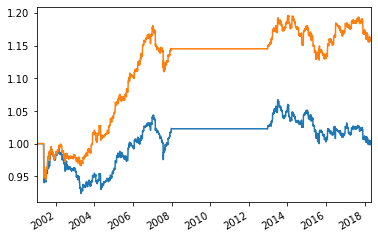

In [8]:
RB = 1
min_vol = .15
freq = 'month'

GRP_bt_test = GRP_bt('vol', ERet, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

In [9]:
print(match.call()[[1]])
name1=match.call()[[1]]
Ret=RETfinal
if(write==1){
setwd("D:/R/GRP/live")

write.csv(TSRV,paste(name1,"TS.csv",sep=""))
write.csv(CSRV,paste(name1,"CS.csv",sep=""))
setwd("D:/R/GRP")
}
if(test!=1){

setwd("D:/R/GRP/live")
##########
TSRVnew=TSRV
CSRVnew=CSRV
TSRVlive=as.data.frame(read.csv(paste(name1,"TS.csv",sep=""), row.names=1,header=TRUE))
CSRVlive=as.data.frame(read.csv(paste(name1,"CS.csv",sep=""), row.names=1,header=TRUE))
TSRVnew[rownames(TSRVlive),]=TSRVlive
CSRVnew[rownames(CSRVlive),]=CSRVlive

if (updatedaily==1){
write.csv(TSRVnew,paste(name1,"TS.csv",sep=""))
write.csv(CSRVnew,paste(name1,"CS.csv",sep=""))
##########
}
setwd("D:/R/GRP")
}
functionoutput=factor(TSRV,CSRV,Ret,FALSE,CSLS=CSdesign,TSWGT,CSWGT,0,CSweek=0,rpname=name1,BETA=betamat1)

result=list(functionoutput[[1]],functionoutput[[2]],functionoutput[[3]],functionoutput[[4]])
result



SyntaxError: invalid syntax (<ipython-input-9-393a9965cdd1>, line 7)